In [155]:
import numpy as np
from scipy.special import expit
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [156]:
def multinomial_encoder(y):
    y = y.reshape(-1, 1)
    m, n = y.shape
    nb_class = np.unique(y).shape[0]
    #we got number from 0 to 9
    y_encod = np.zeros((m, nb_class))
    for k in range(m):
        class_ = y[k]
        y_encod[k, class_] += 1
    return y_encod

In [157]:
class GradientBoosting:

    def __init__(self, method, n_estimators, tree_params, learning_rate):
        if method not in ['regression', 'binary', 'multinomial'] :
            raise ValueError('Please select a method between regression, binary and multinomial')
        self.method = method
        self.learning_rate = learning_rate
        if self.method == 'regression':
            self.models = [DecisionTreeRegressor(**tree_params) for _ in range(n_estimators)]
        else :
            self.models = [DecisionTreeClassifier(**tree_params) for _ in range(n_estimators)]

    def grad(self, y, h):
        return y - h

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims=True)


    def predict(self, X, models):
        learning_rate = self.learning_rate  ##hard code for now
        if self.method == 'regression' :
            f0 = models[0].predict(X)  #first use the dummy model
            boosting = sum(learning_rate * model.predict(X) for model in models[1:])
            return f0 + boosting
        elif self.method == 'binary':
            f0 = models[0].predict(X)  #first use the dummy model
            boosting = sum(learning_rate * model.predict(X) for model in models[1:])
            yhat = f0 + boosting
            yhat =  np.round(expit(yhat))
            return yhat
        else :
            f0 = models[0].predict(X)  #first use the dummy model
            boosting = sum(learning_rate * model.predict(X) for model in models[1:])
            yhat = f0 + boosting
            yhat = self.softmax(yhat)
            yhat = np.argmax(yhat, axis = 1)
            yhat = multinomial_encoder(yhat)
            return yhat

    def fit_data(self, X, y):
        models_trained = []
        #using DummyRegressor is a good technique for starting model
        if self.method == 'regression':
            first_model = DummyRegressor(strategy = 'mean')
        else :  
            first_model = DummyClassifier(strategy='stratified')
        first_model.fit(X, y)
        models_trained.append(first_model)
        #fit the estimators
        for i, model in enumerate(self.models):
            #predict using all the weak learners we trained up to
            #this point
            y_pred = self.predict(X, models_trained)
            #errors will be the total errors maded by models_trained
            residual = self.grad(y, y_pred)
            #fit the next model with residual
            model.fit(X, residual)
            models_trained.append(model)
        return models_trained

In [158]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [159]:
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

n_estimators = 200
tree_params = {'max_depth': 4, 'min_samples_split': 2}
exp = GradientBoosting('regression', n_estimators, tree_params, learning_rate=0.1)


#fit the models
models = exp.fit_data(X_train, y_train)

#predict
y_pred = exp.predict(X_test, models)

#print metrics
print("Our MSE: ", mean_squared_error(y_test, y_pred))

Our MSE:  8.381549935416325


If we tweak a little bit with *max_depth* and *min_samples_split* parameters, we can achieve better performance. The maximum depth of the tree is the most influent parameter. 

In [160]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report

In [161]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

n_estimators = 200
tree_params = {'max_depth': 3, 'min_samples_split': 2}
learning_rate = 0.1
exp = GradientBoosting('binary', n_estimators, tree_params, learning_rate)

#fit the models
models = exp.fit_data(X_train, y_train)

#predict
y_pred = exp.predict(X_test, models)
#print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        63
           1       0.84      0.81      0.82       108

    accuracy                           0.78       171
   macro avg       0.77      0.78      0.77       171
weighted avg       0.79      0.78      0.79       171



In [162]:
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
import seaborn as sns

Accuracy:  0.7018518518518518


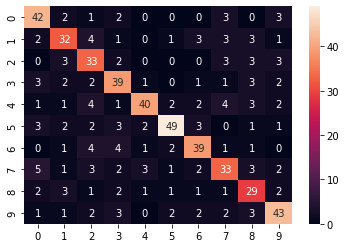

In [163]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


n_estimators = 200
y_train = multinomial_encoder(y_train)
tree_params = {'max_depth': 8, 'min_samples_split': 4}
learning_rate = 0.1
exp = GradientBoosting('multinomial', n_estimators, tree_params, learning_rate)

#fit the models
models = exp.fit_data(X_train, y_train)

#predict
y_pred = exp.predict(X_test, models)
y_pred = np.argmax(y_pred, axis = 1)
#print metrics
print('Accuracy: ', y_test[y_pred == y_test].shape[0] / y_test.shape[0])
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)

The multinomial method is the one which give the worst accuracy with the longest computation time.

In [164]:
exp = GradientBoosting('gaussian', n_estimators, tree_params, learning_rate)

ValueError: ignored